# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [102]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [103]:
def plot_svd_coarsening_accuracy(level, num_sweeps: int, aggregate_size: int, num_components):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
     
    # Create relaxed TVs.
    x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4)
    b = np.zeros_like(x_random)
    x = hm.solve.run.run_iterative_method(
       level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    
    #x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4 * aggregate_size)
    #b = np.zeros_like(x_random)
    #x = hm.solve.run.run_iterative_method(
    #    level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    #start, end = 0, aggregate_size
    #x_aggregate_t = x[start:end].transpose()
    #print(x_aggregate_t.shape)
    #r, s = hm.repetitive.coarsening_repetitive.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()
    display(pd.DataFrame(r))

    # Relaxed vectors.
    ax = axs[0]
    for i in range(min(3, x.shape[1])):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);

    # TODO: replace by local mock cycle rate.
    nu_values = np.arange(1, 12)
    R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
    print("nu", "{:3d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
    #hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv {}".format(np.array2string(mock_conv, precision=3)))

#         # Generate coarse variables (R) on the non-repetitive domain.
#         r, aggregates, nc, energy_error = hm.repetitive.coarsening_repetitive.create_coarsening_domain(
#             x, threshold=threshold, fixed_aggregate_size=aggregate_size)
#         _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
#         _LOGGER.info("nc  {}".format(nc))
#         _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [104]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
kh = 0
#kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0


## Level 0->1 Coarsening

In [105]:
kh = 0

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.363e+00                    4.470e-01    3.049
INFO     1     5.393e-01 (0.396) [0.396]    2.739e-01    1.977 (0.647)
INFO     2     2.250e-01 (0.418) [0.407]    2.075e-01    1.098 (0.554)
INFO     3     1.019e-01 (0.453) [0.422]    1.770e-01    0.592 (0.536)
INFO     4     5.285e-02 (0.518) [0.444]    1.592e-01    0.347 (0.581)
INFO     5     3.171e-02 (0.599) [0.472]    1.475e-01    0.229 (0.652)
INFO     6     2.152e-02 (0.677) [0.501]    1.389e-01    0.168 (0.724)
INFO     7     1.591e-02 (0.738) [0.530]    1.322e-01    0.132 (0.780)
INFO     8     1.245e-02 (0.782) [0.556]    1.268e-01    0.109 (0.819)
INFO     9     1.015e-02 (0.815) [0.580]    1.224e-01    0.092 (0.848)
INFO     10    8.505e-03 (0.839) [0.602]    1.185e-01    0.080 (0.869)
INFO     11    7.289e-03 (0.858) [0.622]    1.152e-01    0.070 (0.885)
INFO     12    6.357e-03 (0.873) [0.640]    1.123e-01    0.063 (0.898)
INFO 

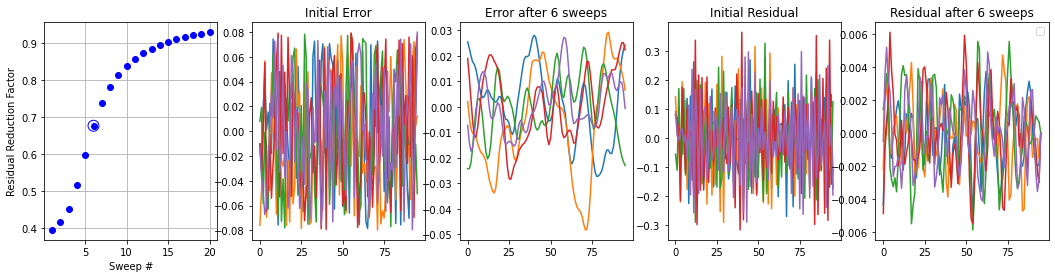

In [106]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

Moviepy - Building video laplace_shrinkage.mp4.
Moviepy - Writing video laplace_shrinkage.mp4



Moviepy - Done !
Moviepy - video ready laplace_shrinkage.mp4


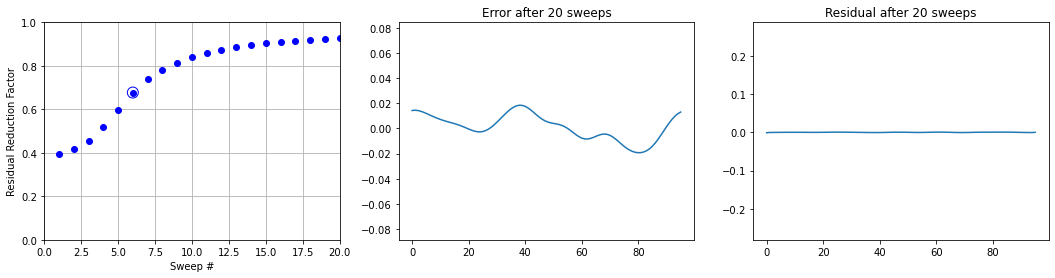

In [107]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
animation.write_videofile("laplace_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [108]:
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
print("kh", kh)

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

kh 0.523385380551301


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.239e+00                    4.469e-01    2.775
INFO     1     4.155e-01 (0.336) [0.336]    3.068e-01    1.361 (0.490)
INFO     2     1.837e-01 (0.443) [0.386]    2.704e-01    0.684 (0.503)
INFO     3     1.149e-01 (0.625) [0.453]    2.542e-01    0.454 (0.665)
INFO     4     8.925e-02 (0.775) [0.519]    2.437e-01    0.368 (0.809)
INFO     5     7.628e-02 (0.853) [0.573]    2.355e-01    0.325 (0.882)
INFO     6     6.815e-02 (0.892) [0.617]    2.286e-01    0.298 (0.919)
INFO     7     6.238e-02 (0.915) [0.653]    2.226e-01    0.280 (0.940)
INFO     8     5.798e-02 (0.929) [0.682]    2.173e-01    0.267 (0.952)
INFO     9     5.443e-02 (0.939) [0.707]    2.124e-01    0.256 (0.961)
INFO     10    5.147e-02 (0.946) [0.728]    2.080e-01    0.248 (0.966)
INFO     11    4.892e-02 (0.951) [0.746]    2.038e-01    0.240 (0.970)
INFO     Relax conv 0.95 shrinkage 0.39 PODR RER 0.68 after 2 sweeps. Work 1

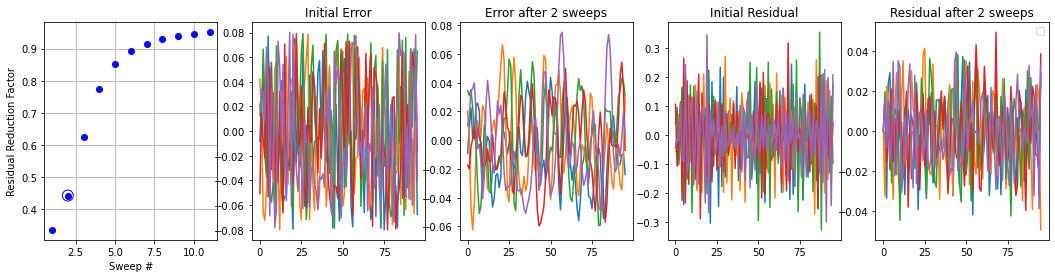

In [109]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

Moviepy - Building video kaczmarz_shrinkage.mp4.
Moviepy - Writing video kaczmarz_shrinkage.mp4



Moviepy - Done !
Moviepy - video ready kaczmarz_shrinkage.mp4


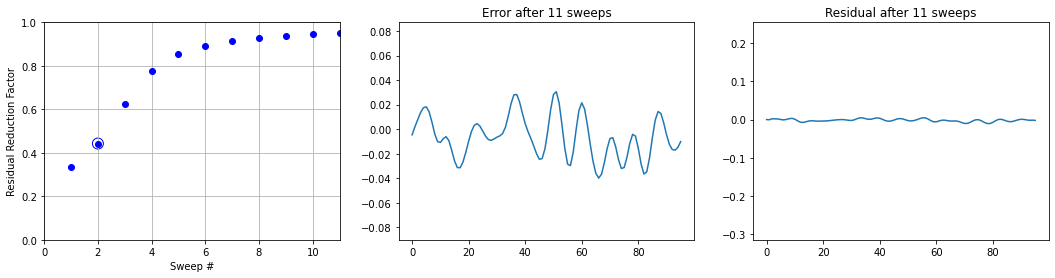

In [110]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
animation.write_videofile("kaczmarz_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [111]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 30 sweeps
INFO     RER 0.155


### Coarsening: Fixed (4/2)

In [112]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3
0,-0.4562,-0.5692,-0.5493,-0.4076
1,-0.6440,-0.2299,0.2702,0.6777


nu  30 s [1.    0.598 0.085 0.013] Energy error [0.517 0.073 0.011 0.   ]
INFO     Mock cycle conv [0.505 0.281 0.154 0.11  0.064 0.07  0.06  0.048 0.047 0.038 0.044]


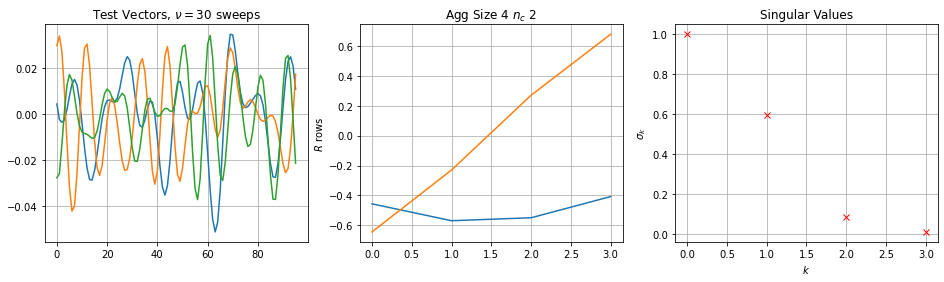

In [113]:
plot_svd_coarsening_accuracy(level, 30, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.4295,-0.5703,-0.5638,-0.4152,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6562,0.2433,-0.2545,-0.6674,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4295,-0.5703,-0.5638,-0.4152,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6562,0.2433,-0.2545,-0.6674,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4295,-0.5703


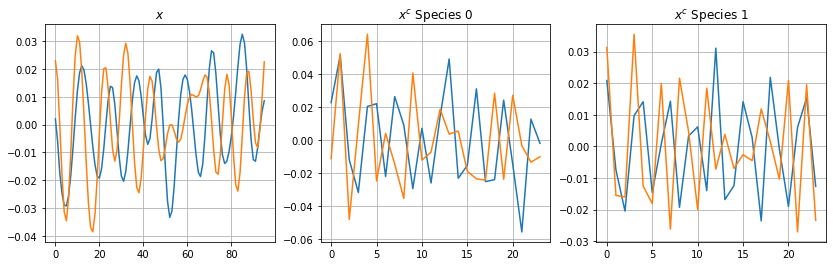

In [114]:
aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [115]:
num_sweeps = max(num_sweeps, 7)

In [116]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 5
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=20 [0.536 0.294 0.151 0.116 0.087 0.069 0.052]


### Interpolation $P = R^T$

In [117]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.81


### Interpolation by LS Fitting

In [118]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7
Mock,nan,nan,nan,nan,nan,0.5356,0.2940,0.1514,0.1161,0.0868,0.0690,0.0516
P=R^T,nan,nan,nan,nan,nan,0.5841,0.4543,0.3880,0.3503,0.3199,0.2794,0.2625
P^T A P caliber 2,0.0000,2.0000,192.0000,1.2000,0.0000,0.5822,0.4583,0.3907,0.3764,0.3392,0.3272,0.3071
P^T A P caliber 3,0.0000,3.0000,288.0000,1.4000,0.0000,0.5400,0.3782,0.2996,0.2589,0.2229,0.2056,0.2115
P^T A P caliber 4,0.0000,4.0000,384.0000,2.0000,0.0000,0.5165,0.2690,0.1450,0.0909,0.0662,0.0534,0.0436
R A P caliber 2,1.0000,2.0000,192.0000,1.2000,0.0170,0.5795,0.4364,0.3926,0.3781,0.3493,0.3394,0.3258
R A P caliber 3,1.0000,3.0000,288.0000,1.2000,0.0142,0.5765,0.4071,0.3418,0.2981,0.2945,0.2758,0.2613
R A P caliber 4,1.0000,4.0000,384.0000,1.2000,0.0046,0.5115,0.2585,0.1731,0.1184,0.0901,0.0721,0.0610


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [119]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.4283,0.6651
1,-0.5713,0.2330
2,-0.5648,-0.2546
3,-0.4122,-0.6572


A^1


,0,1,2,3,4,5
0,-0.1690,0.0197,0.1956,-0.3262,0.1956,0.3349
1,0.0197,-1.4564,0.3349,-0.5559,-0.3262,-0.5559


caliber 3 P


,0,1,2,3
0,-0.4488,0.5811,0.0000,-0.0606
1,-0.5538,0.2944,0.0000,0.0458
2,-0.5480,-0.3130,0.0447,0.0000
3,-0.4352,-0.5749,-0.0641,0.0000


A^1


,0,1,2,3,4,5,6,7
0,-0.0935,0.0129,0.1832,-0.2584,0.0032,0.0032,0.1832,0.2643
1,0.0129,-1.1496,0.2643,-0.4162,0.0000,0.0000,-0.2584,-0.4162


caliber 4 P


,0,1,2,3,4,5
0,-0.3913,0.4342,0.0000,0.0000,-0.1050,-0.1617
1,-0.5930,0.3983,0.0000,0.0000,0.0783,0.1079
2,-0.5845,-0.4090,0.0790,-0.1041,0.0000,0.0000
3,-0.3758,-0.4287,-0.1146,0.1714,0.0000,0.0000


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.0591,0.0065,0.1574,-0.2179,0.0097,-0.0129,0.0097,0.0135,0.1574,0.2233
1,0.0065,-0.8934,0.2233,-0.3047,0.0135,-0.0179,-0.0129,-0.0179,-0.2179,-0.3047


R*A*P
caliber 2 P


,0,1
0,-0.4283,0.6651
1,-0.5713,0.2330
2,-0.5648,-0.2546
3,-0.4122,-0.6572


A^1


,0,1,2,3,4,5
0,-0.1700,0.0180,0.1972,-0.3289,0.1963,0.3361
1,0.0153,-1.4565,0.3403,-0.5648,-0.3214,-0.5478


caliber 3 P


,0,1,2,3
0,-0.4488,0.5811,0.0000,-0.0606
1,-0.5538,0.2944,0.0000,0.0458
2,-0.5480,-0.3130,0.0447,0.0000
3,-0.4352,-0.5749,-0.0641,0.0000


A^1


,0,1,2,3,4,5
0,-0.1132,0.0158,0.1930,-0.2842,0.1933,0.2907
1,0.0102,-1.2640,0.2844,-0.4884,-0.2721,-0.4742


caliber 4 P


,0,1,2,3,4,5
0,-0.3913,0.4342,0.0000,0.0000,-0.1050,-0.1617
1,-0.5930,0.3983,0.0000,0.0000,0.0783,0.1079
2,-0.5845,-0.4090,0.0790,-0.1041,0.0000,0.0000
3,-0.3758,-0.4287,-0.1146,0.1714,0.0000,0.0000


A^1


,0,1,2,3,4,5
0,-0.0332,0.0044,0.1507,-0.1660,0.1494,0.1691
1,0.0084,-0.6265,0.1737,-0.1564,-0.1683,-0.1583


In [120]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $R A P$

INFO         0 |r| 1.774e+01 RER 3.40139
INFO         1 |r| 1.396e+00 (0.07870) RER 0.03669 (0.01079) 38.044
INFO         2 |r| 1.521e-01 (0.10894) RER 0.00425 (0.11582) 35.784
INFO         3 |r| 2.477e-02 (0.16286) RER 0.00070 (0.16574) 35.162
INFO         4 |r| 4.628e-03 (0.18687) RER 0.00013 (0.18752) 35.040
INFO         5 |r| 8.686e-04 (0.18768) RER 0.00002 (0.18780) 35.018
INFO         6 |r| 1.600e-04 (0.18423) RER 0.00000 (0.18425) 35.015
INFO         7 |r| 2.886e-05 (0.18037) RER 0.00000 (0.18037) 35.014
INFO         8 |r| 5.123e-06 (0.17751) RER 0.00000 (0.17751) 35.014
INFO         9 |r| 8.987e-07 (0.17540) RER 0.00000 (0.17540) 35.014
INFO        10 |r| 1.563e-07 (0.17392) RER 0.00000 (0.17392) 35.014
INFO        11 |r| 2.702e-08 (0.17288) RER 0.00000 (0.17288) 35.014
INFO        12 |r| 4.652e-09 (0.17218) RER 0.00000 (0.17218) 35.014
INFO        13 |r| 7.992e-10 (0.17178) RER 0.00000 (0.17178) 35.014
INFO        14 |r| 1.375e-10 (0.17209) RER 0.00000 (0.17209) 35.014
INFO   

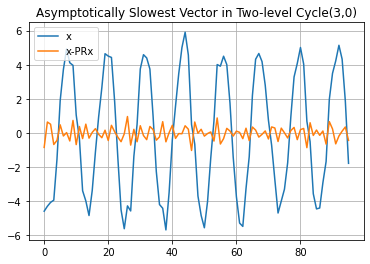

In [121]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [122]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [ 0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.167  0.167]


In [123]:
m0[1].a

<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 288 stored elements in Compressed Sparse Row format>

In [124]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,-0.0332,0.0044,0.1507,-0.1660,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0084,-0.6265,0.1737,-0.1564,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.1494,0.1691,-0.0332,0.0044,0.1507,-0.1660,0.0000,0.0000,0.0000,0.0000
3,-0.1683,-0.1583,0.0084,-0.6265,0.1737,-0.1564,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.1494,0.1691,-0.0332,0.0044,0.1507,-0.1660,0.0000,0.0000
5,0.0000,0.0000,-0.1683,-0.1583,0.0084,-0.6265,0.1737,-0.1564,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.1494,0.1691,-0.0332,0.0044,0.1507,-0.1660
7,0.0000,0.0000,0.0000,0.0000,-0.1683,-0.1583,0.0084,-0.6265,0.1737,-0.1564
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1494,0.1691,-0.0332,0.0044
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1683,-0.1583,0.0084,-0.6265


In [125]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,-0.0040,0.0013,0.0023,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0040,0.0000,0.0046,0.0019,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0013,-0.0046,0.0000,-0.0040,0.0013,0.0023,0.0000,0.0000,0.0000,0.0000
3,-0.0023,-0.0019,0.0040,0.0000,0.0046,0.0019,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,-0.0013,-0.0046,0.0000,-0.0040,0.0013,0.0023,0.0000,0.0000
5,0.0000,0.0000,-0.0023,-0.0019,0.0040,0.0000,0.0046,0.0019,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,-0.0013,-0.0046,0.0000,-0.0040,0.0013,0.0023
7,0.0000,0.0000,0.0000,0.0000,-0.0023,-0.0019,0.0040,0.0000,0.0046,0.0019
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0013,-0.0046,0.0000,-0.0040
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0023,-0.0019,0.0040,0.0000


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [126]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [127]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.407e-01                    4.454e-01    0.541
INFO     1     5.811e-02 (0.240) [0.240]    2.321e-01    0.249 (0.461)
INFO     2     3.608e-02 (0.622) [0.386]    1.920e-01    0.188 (0.752)
INFO     3     2.570e-02 (0.712) [0.473]    1.704e-01    0.152 (0.803)
INFO     4     1.962e-02 (0.761) [0.533]    1.568e-01    0.128 (0.830)
INFO     5     1.569e-02 (0.796) [0.578]    1.473e-01    0.111 (0.851)
INFO     6     1.299e-02 (0.823) [0.614]    1.404e-01    0.098 (0.869)
INFO     7     1.106e-02 (0.846) [0.643]    1.350e-01    0.088 (0.885)
INFO     8     9.637e-03 (0.865) [0.668]    1.307e-01    0.081 (0.899)
INFO     9     8.552e-03 (0.881) [0.689]    1.271e-01    0.075 (0.911)
INFO     10    7.698e-03 (0.894) [0.708]    1.241e-01    0.070 (0.920)
INFO     11    7.005e-03 (0.904) [0.725]    1.215e-01    0.066 (0.928)
INFO     12    6.428e-03 (0.912) [0.739]    1.192e-01    0.063 (0.935)
INFO 

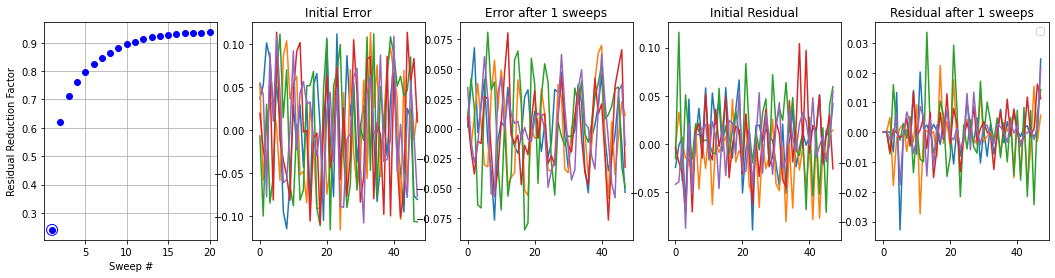

In [128]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

,0,1,2,3
0,-0.6683,0.2310,0.6602,0.2532
1,-0.4685,-0.5297,-0.4859,0.5137


nu 100 s [1.    0.804 0.001 0.   ] Energy error [0.626 0.001 0.    0.   ]
INFO     Mock cycle conv [0.47  0.256 0.173 0.134 0.104 0.067 0.066 0.051 0.044 0.037 0.033]


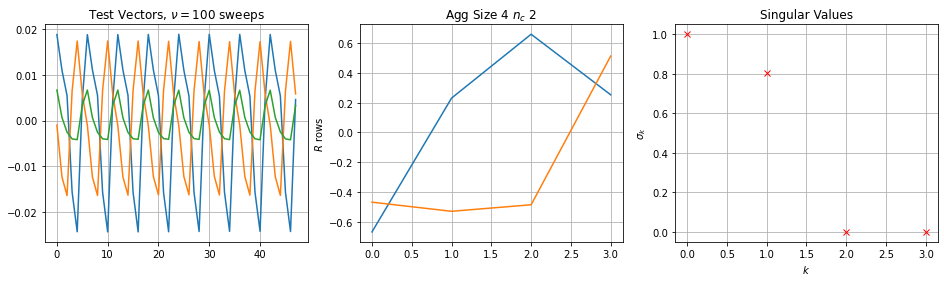

In [129]:

# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [130]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1494,0.1691,-0.0332,0.0044,0.1507,-0.1660
1,-0.1683,-0.1583,0.0084,-0.6265,0.1737,-0.1564


In [131]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.000


In [132]:
#plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [133]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size//2:]

In [134]:
 # np.correlate(x[:, 0], x[:, 0], mode='full')

[1.    0.824 0.001 0.   ]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,-0.6743,0.2241,0.6538,0.2599,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.4597,0.5326,0.4944,-0.5104,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.6743,0.2241,0.6538,0.2599,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.4597,0.5326,0.4944,-0.5104,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6743,0.2241


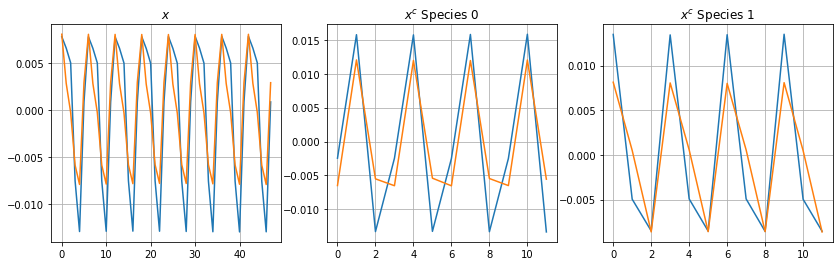

In [135]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Mock Cycle Rate

In [136]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.44  0.255 0.179 0.136 0.105 0.064 0.067 0.049 0.039 0.033 0.03 ]


In [137]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [138]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.46


### Interpolation by LS Fitting

In [185]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        #print(a.shape, R.shape, level.location.shape)
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.44,0.25,0.18,0.14,0.11,0.06,0.07,0.05,0.04,0.03,0.03
P=R^T,nan,nan,nan,nan,nan,5.68,4.79,3.81,3.01,2.39,1.89,1.51,1.30,1.16,1.06,0.98
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,5.68,4.79,3.81,3.02,2.39,1.88,1.55,1.22,1.21,1.09,0.94
P^T A P caliber 3,0.00,3.00,144.00,1.17,0.00,0.58,0.43,0.33,0.28,0.23,0.20,0.19,0.18,0.16,0.16,0.15
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,3.01,1.37,0.49,0.16,0.06,0.12,0.14,0.14,0.14,0.14,0.13
R A P caliber 2,1.00,2.00,96.00,1.00,0.00,5.68,4.79,3.81,3.02,2.39,1.89,1.54,1.24,1.19,1.03,0.96
R A P caliber 3,1.00,3.00,144.00,1.00,0.01,1.54,1.38,1.12,0.87,0.59,0.49,0.46,0.45,0.47,0.45,0.42
R A P caliber 4,1.00,4.00,192.00,1.00,0.01,13.23,5.63,1.68,0.24,0.15,0.19,0.17,0.13,0.09,0.07,0.04


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 3.550e+00 RER 1.01838
INFO         1 |r| 6.743e-01 (0.18994) RER 0.16440 (0.16143) 4.102
INFO         2 |r| 2.283e-01 (0.33858) RER 0.05906 (0.35926) 3.865
INFO         3 |r| 3.256e-02 (0.14260) RER 0.00850 (0.14388) 3.831
INFO         4 |r| 4.360e-03 (0.13392) RER 0.00114 (0.13387) 3.833
INFO         5 |r| 6.712e-04 (0.15395) RER 0.00018 (0.15393) 3.833
INFO         6 |r| 1.061e-04 (0.15812) RER 0.00003 (0.15812) 3.833
INFO         7 |r| 1.633e-05 (0.15385) RER 0.00000 (0.15385) 3.833
INFO         8 |r| 2.492e-06 (0.15262) RER 0.00000 (0.15262) 3.833
INFO         9 |r| 3.821e-07 (0.15334) RER 0.00000 (0.15334) 3.833
INFO        10 |r| 5.872e-08 (0.15367) RER 0.00000 (0.15367) 3.833
INFO        11 |r| 9.016e-09 (0.15355) RER 0.00000 (0.15355) 3.833
INFO        12 |r| 1.384e-09 (0.15347) RER 0.00000 (0.15347) 3.833
INFO        13 |r| 2.124e-10 (0.15348) RER 0.00000 (0.15348) 3.833
INFO        14 |r| 3.260e-11 (0.15351) RER 0.00000 (0.15351) 3.833


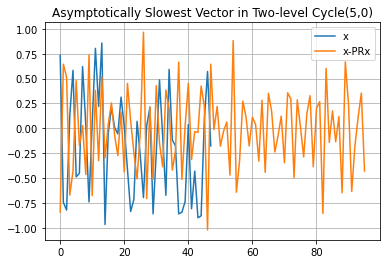

In [178]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 5
p = p_experiment[True][-1]  # P^T*A*P P high order
use_r_as_restriction = True

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [141]:
m1[1].a

<24x24 sparse matrix of type '<class 'numpy.float64'>'
	with 144 stored elements in Compressed Sparse Row format>

In [142]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.    -0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.167  0.167]
1 lam [-0.    -0.     0.001  0.014  0.014  0.051  0.051  0.058  0.058 -0.075 -0.075  0.08 ]


## 3-Level Method

In [143]:
m0.add(m1[1])

INFO         0 |r| 1.657e+01 RER 2.87542
INFO         1 |r| 1.319e-01 (0.00796) RER 0.00692 (0.00241) 19.067
INFO         2 |r| 5.593e-03 (0.04241) RER 0.00028 (0.04031) 20.062
INFO         3 |r| 3.145e-04 (0.05622) RER 0.00002 (0.05609) 20.109
INFO         4 |r| 4.591e-05 (0.14598) RER 0.00000 (0.14596) 20.112
INFO         5 |r| 7.033e-06 (0.15320) RER 0.00000 (0.15319) 20.113
INFO         6 |r| 9.899e-07 (0.14075) RER 0.00000 (0.14075) 20.113
INFO         7 |r| 1.357e-07 (0.13708) RER 0.00000 (0.13708) 20.113
INFO         8 |r| 1.848e-08 (0.13618) RER 0.00000 (0.13618) 20.113
INFO         9 |r| 2.513e-09 (0.13598) RER 0.00000 (0.13598) 20.113
INFO        10 |r| 3.416e-10 (0.13595) RER 0.00000 (0.13595) 20.113
INFO        11 |r| 4.644e-11 (0.13593) RER 0.00000 (0.13593) 20.113


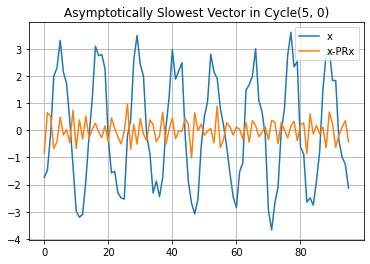

In [183]:
nu_pre = 5
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [145]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [ 0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.167  0.167]
2 lam [-0.    -0.     0.001  0.014  0.014  0.051  0.051  0.058  0.058 -0.075 -0.075  0.08 ]


In [146]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

In [147]:
pd.DataFrame(m1[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0285,-0.0327,-0.0257,0.0148,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0180,-0.0043,-0.0638,-0.0872,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0314,-0.0671,0.0285,-0.0327,-0.0257,0.0148,0.0000,0.0000,0.0000,0.0000
3,0.0170,-0.0955,-0.0180,-0.0043,-0.0638,-0.0872,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,-0.0314,-0.0671,0.0285,-0.0327,-0.0257,0.0148,0.0000,0.0000
5,0.0000,0.0000,0.0170,-0.0955,-0.0180,-0.0043,-0.0638,-0.0872,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,-0.0314,-0.0671,0.0285,-0.0327,-0.0257,0.0148
7,0.0000,0.0000,0.0000,0.0000,0.0170,-0.0955,-0.0180,-0.0043,-0.0638,-0.0872
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0314,-0.0671,0.0285,-0.0327
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0170,-0.0955,-0.0180,-0.0043


In [148]:
pd.DataFrame((m1[1].a - m1[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,-0.0147,0.0056,-0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0147,0.0000,0.0033,0.0083,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0056,-0.0033,0.0000,-0.0147,0.0056,-0.0022,0.0000,0.0000,0.0000,0.0000
3,0.0022,-0.0083,0.0147,0.0000,0.0033,0.0083,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,-0.0056,-0.0033,0.0000,-0.0147,0.0056,-0.0022,0.0000,0.0000
5,0.0000,0.0000,0.0022,-0.0083,0.0147,0.0000,0.0033,0.0083,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,-0.0056,-0.0033,0.0000,-0.0147,0.0056,-0.0022
7,0.0000,0.0000,0.0000,0.0000,0.0022,-0.0083,0.0147,0.0000,0.0033,0.0083
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0056,-0.0033,0.0000,-0.0147
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0022,-0.0083,0.0147,0.0000


In [164]:
ac = pd.DataFrame(m0[1]._r.dot(m0[0].a.dot(m0[1]._r.T)).todense()[2:4, :6])
styler = ac.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,0,1,2,3,4,5
0,0.20,0.34,-0.17,0.01,0.20,-0.32
1,-0.32,-0.56,0.01,-1.46,0.34,-0.56


In [165]:
ac = pd.DataFrame(m0[1]._r.dot(m0[0].a.dot(m0[1]._p)).todense()[2:4, :6])
styler = ac.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,0,1,2,3,4,5
0,0.15,0.17,-0.03,0.00,0.15,-0.17
1,-0.17,-0.16,0.01,-0.63,0.17,-0.16


In [166]:
ac = pd.DataFrame(m0[0].a.todense()[2, :5])
styler = ac.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,0,1,2,3,4
0,-0.08,1.33,-2.23,1.33,-0.08
